## Note: This is the notebook group 66 members have for Project D, the numbering of section corresponds to the numbering of our report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import files
uploaded = files.upload()

Saving NHANESI_X.csv to NHANESI_X (4).csv
Saving NHANESI_y.csv to NHANESI_y (4).csv


In [3]:
x = pd.read_csv('NHANESI_X.csv').drop(columns=['Unnamed: 0'])
y = pd.read_csv('NHANESI_y.csv').drop(columns=['Unnamed: 0'])

### 2. Data

There are 9932 observations and 18 predictors in the dataset including medical survey information and demographic attributes. The outcome is the log odds of mortality after a certain age. 

#### 2.1 Missing value

A brief summary shows us that the missing data doesn't pose a severe problem and they are most likely due to missing not at random. Only 5 columns have missing values, among which, `pulse pressure`, `diastolic BP` and `systolic BP` miss only less than 0.6% data, while `white blood cells` misses 10%. Notably, pulse pressure is calculated from the difference between diastolic and systolic BP, so the missing is inter-correlated and we can use multiple imputing to learn this relationship for imputation. For white blood cells, the missing is not non-trivial, and multiple imputation can also be more robust in this case. 

In [4]:
data=x.copy()
data['y']=y['y']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9932 non-null   float64
 1   Diastolic BP        9874 non-null   float64
 2   Poverty index       9932 non-null   float64
 3   Race                9932 non-null   float64
 4   Red blood cells     9932 non-null   float64
 5   Sedimentation rate  9106 non-null   float64
 6   Serum Albumin       9932 non-null   float64
 7   Serum Cholesterol   9932 non-null   float64
 8   Serum Iron          9932 non-null   float64
 9   Serum Magnesium     9932 non-null   float64
 10  Serum Protein       9932 non-null   float64
 11  Sex                 9932 non-null   float64
 12  Systolic BP         9875 non-null   float64
 13  TIBC                9932 non-null   float64
 14  TS                  9932 non-null   float64
 15  White blood cells   8891 non-null   float64
 16  BMI   

In [5]:
mis_prop=np.round(data.isna().sum(axis=0)/len(data),4)
pd.DataFrame({'predictor':mis_prop.index,'missing proportion':mis_prop.values*100}).sort_values(by='missing proportion',ascending=False)#.reset_index().rename(columns={'index':'predictor','0':'missing prop'})

,predictor,missing proportion
15,White blood cells,10.48
5,Sedimentation rate,8.32
17,Pulse pressure,0.59
1,Diastolic BP,0.58
12,Systolic BP,0.57
0,Age,0.00
11,Sex,0.00
16,BMI,0.00
14,TS,0.00
13,TIBC,0.00


#### 2.2 Data Processing

Due to theinformation that the response variable encodes, we  convert the response variable into a binary variablebased on its positiveness because we believe that whether someone died before or after the end of study is more meaningful than the numerical values themselves.

In [6]:
data["Age"] = pd.cut(data.Age, [0, 45, 65, max(data.Age)],labels=['Young','Middle Age','Elder'])

In [7]:
# convert `y` to binary --- 
y=1.0*(data['y']>0)
y.value_counts()

0.0    6459
1.0    3473
Name: y, dtype: int64

#### 2.3 Explaintory Data Analysis

##### Train-test Split

We perform a 80-20 train-test split on the original dataset and conduct the exploratory data analysis (EDA) on the training set. 

- Note on variable names:
  - `x_train`, `y_train`: original independent variables (18 columns) with binary response variable
    - `train`: copy of `x_train`; this dataframe will be modified for EDA purpose
  - `x_train_con`, `y_train_con`: original independent variables (18 columns) with continuous/original response variable

In [8]:
#split train & test before EDA; EDA using train set only

# binary y
x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=66)
# continuous y
x_train_con, x_test_con, y_train_con, y_test_con = train_test_split(x, data["y"].values,test_size=0.2,random_state=66)

In [9]:
# Use `train` for EDA, a copy of x_train
train=pd.DataFrame(x_train,columns=data.columns[:18])

# cut age into categorical
train.Age = pd.cut(train.Age, [0, 45, 65, max(train.Age)],labels=['Young','Middle Age','Elder'])

##### Distribution of the response variable

From the histogram plot of outcome -- log odds of mortality rate, the distribution right-skewed with a peak in -20 and a flat spread between 0 and 20. This indicates that the distribution of mortality tends to be a inequal bimodel that half of people are safe from death (the odds of -10 is almost zero), while the other half suffers a motality odds from 1 to $e^{20}$.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


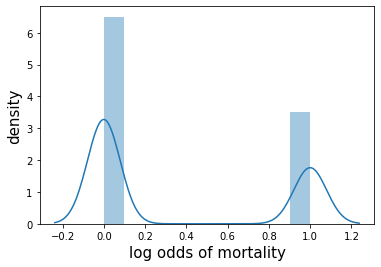

In [10]:
ax=plt.subplot(111)
sns.distplot(y_train,ax=ax)
ax.set_xlabel('log odds of mortality',fontsize=15)
ax.set_ylabel('density',fontsize=15)
plt.savefig('distribution_y.pdf')


##### Distribution of `Race` and `Age`
1. From the histogram we can see that the distribution of `Race` is highly disproportional, only 1% of the train data are black, while the vast majority (81%) of people are white. 
2. Grouping `Age` to  3  categories  including `Young`, `Middle Age`,  and `Elder` based on their medical  definitions, we find that for all race groups, young people have the highest proportion.`White` group has a significantly higher percentage of young people, and relatively similar middle aged and elderly people.  For `Black` and `Other` racial groups, the differences among the number of young, middle aged, and elderly people are lesssignificant.

         Race
white  0.8121
other  0.1775
black  0.0104


Text(0.5, 1.0, 'Race distribution in dataset')

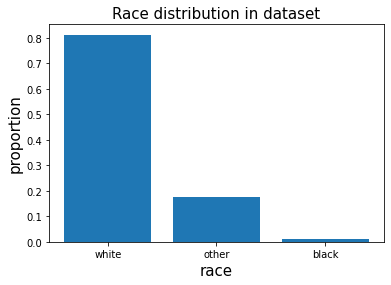

In [11]:
m=np.round(train['Race'].value_counts()/len(x_train),4)
m.index=['white','other','black']
print(pd.DataFrame(m))
plt.bar(m.index,m.values)
plt.xlabel('race',fontsize=15)
plt.ylabel('proportion',fontsize=15)
plt.title('Race distribution in dataset',fontsize=15)

In [12]:
train['Sex_mask']=train['Sex'].replace({1:'Male',2:'Female'})
train['Race_mask']=train['Race'].replace({1:'White',2:'Other',3:'Black'})

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


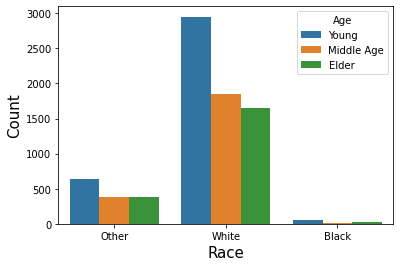

In [13]:
# --- Age-Race plot ---

sns.countplot(train.Race_mask, hue=data.Age)
plt.xlabel('Race',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.savefig('countplot_1.pdf')

##### Distribution of `Sex` and `Age`

`Female` group also has a significantly high percentage of young people. The numbers of observations for middleaged female, elderly female, young male, middle aged male, and elderly male are relatively similar.


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


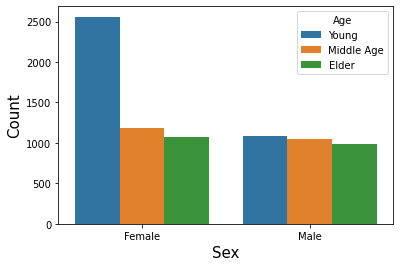

In [14]:
# --- Age-Sex plot ---

sns.countplot(train.Sex_mask, hue=data.Age)
plt.xlabel('Sex',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.savefig('countplot_2.pdf')

In [15]:
# --- Creating `age_sex` column denoting both age and sex labels ---

train['age_sex'] = [0] * len(train)

for i in range(len(train)):
    if train['Sex_mask'].iloc[i] == 'Male':
        if train['Age'].iloc[i] == 'Young':
            train['age_sex'].iloc[i] = 'Male_Young'
        elif train['Age'].iloc[i] == 'Middle Age':
            train['age_sex'].iloc[i] = 'Male_Middle_Age'
        elif train['Age'].iloc[i] == 'Elder':
            train['age_sex'].iloc[i] = 'Male_Elder'
    elif train['Sex_mask'].iloc[i] == 'Female':
        if train['Age'].iloc[i] == 'Young':
            train['age_sex'].iloc[i] = 'Female_Young'
        elif train['Age'].iloc[i] == 'Middle Age':
            train['age_sex'].iloc[i] = 'Female_Middle_Age'
        elif train['Age'].iloc[i] == 'Elder':
            train['age_sex'].iloc[i] = 'Female_Elder'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


##### Relationship Between `Age-Sex` and Other Predictors

- Based on `Poverty index` vs. `Age_sex`, we observe that People with high poverty index tend to die before the end of the study (negative `y` value). This trend is especially obvious for both male and female non-elderly peoplee
- Based on `BMI` vs `Age_sex`, we observe that female of all age groups who die after the end of study (positive `y` value) have a higher `BMI`. This trend does not apply to male as much as to female.
- Based on `Systolcic BP` vs `Age_sex`, we observe that those who die after the end of study (positive `y` value) tend to have higher `Systolcic BP`. We also observe some differences in the distribution of `Systolcic BP` among age groups. For example, middle aged females and elderly males have a nearly normal distribution. Young females, young males, middle aged males, and elderly males have more than 1 peaks for those who die before the end of study (negative `y` value).

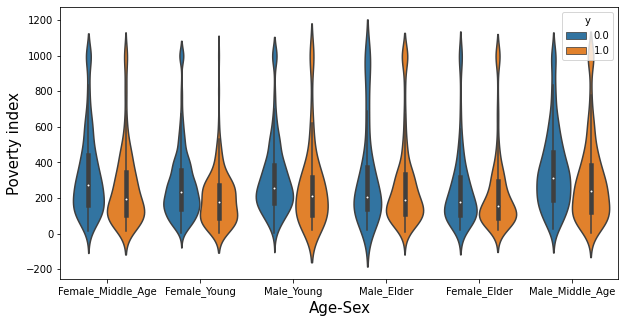

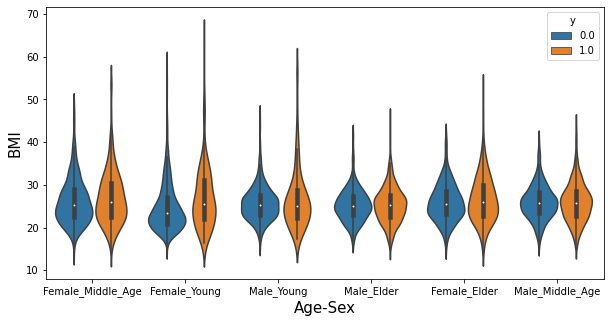

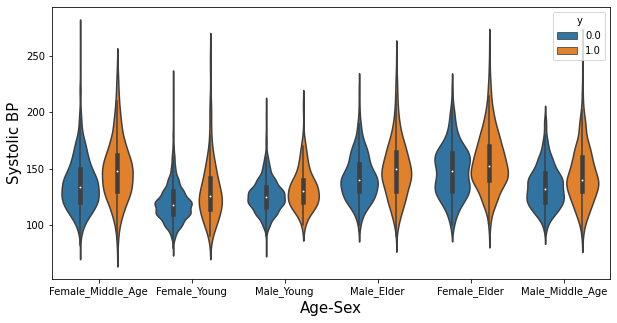

In [16]:
# --- NEW: violin plot using categorical Age & Sex and binary y ---

plt.figure(figsize=(10,5))
sns.violinplot(x = train.age_sex, y=train['Poverty index'], hue=y_train)
plt.xlabel('Age-Sex',fontsize=15)
plt.ylabel('Poverty index',fontsize=15)
plt.savefig('Violin_1.pdf')
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(x = train.age_sex, y=train['BMI'], hue=y_train)
plt.xlabel('Age-Sex',fontsize=15)
plt.ylabel('BMI',fontsize=15)
plt.savefig('Violin_2.pdf')
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(x = train.age_sex, y=train['Systolic BP'], hue=y_train)
plt.xlabel('Age-Sex',fontsize=15)
plt.ylabel('Systolic BP',fontsize=15)
plt.savefig('Violin_3.pdf')
plt.show()


##### Multicollinearity
From the correlation matrix, we can see that the multicollinearity does exist. Pairs of predictor that have high correlations include `TS` and `Serum iron`, `Pulse pressure` and `Systolic BP` (SBP), `SBP` and `Diastolic BP` (DBP). This observation makes sense because `TS` is calculated from `Serum iron`, `Pulse pressure` is calculated from `SBP` and `DBP`

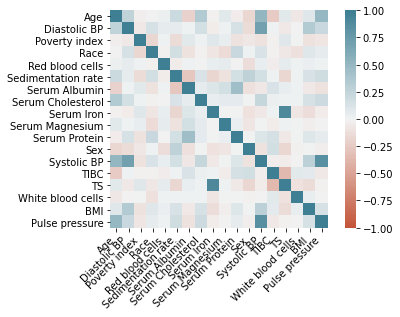

In [17]:
corr = x[[i for i in x.columns if i!='age_mask' or i!='race_mask' or i!='agegrp']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#ax.set_title('Correlation matrix',fontsize=15)
plt.savefig('corr.png')

#### 2.3 Data Handling 

##### Imputation

In [18]:
imp=IterativeImputer(random_state=66)
imp.fit(x_train)
x_train_filled=imp.transform(x_train)
x_test_filled=imp.transform(x_test)

In [19]:
# keep the original form
x_train_orig = x_train_filled.copy()
x_test_orig = x_test_filled.copy()

In [20]:
scaler = StandardScaler()
scaler.fit(x_train_orig)
x_train_orig_sca = scaler.transform(x_train_orig)
x_test_orig_sca = scaler.transform(x_test_orig)

In [21]:
# --- convert imputed data into categorical ---

# back to dataframe

x_train_filled = pd.DataFrame(x_train_filled, columns=data.columns[:18])
x_test_filled = pd.DataFrame(x_test_filled, columns=data.columns[:18])


# split train into labels after imputation

x_train_filled["Age"] = pd.cut(x_train_filled.Age, [0, 45, 65, max(x_train_filled.Age)],labels=['Young','Middle Age','Elder'])
x_train_filled['Diastolic BP'] = pd.cut(x_train_filled['Diastolic BP'], [0, 90, 120, max(x_train_filled['Diastolic BP'])],labels=['Normal','High','Hyper'])
x_train_filled['Systolic BP'] = pd.cut(x_train_filled['Systolic BP'], [0, 140, 180, max(x_train_filled['Systolic BP'])],labels=['Normal','High','Hyper'])
x_train_filled['Pulse pressure'] = pd.cut(x_train_filled['Pulse pressure'], [0, 40,60, max(x_train_filled['Pulse pressure'])],labels=['Low','Normal','High'])


# Sedimentation
x_train_filled['Sedimentation rate'] = pd.cut(x_train_filled['Sedimentation rate'],\
                                              [0, 14, 29, max(x_train_filled['Sedimentation rate'])],labels=['Low','Median','High'])

x_train_filled['Serum Cholesterol'] = pd.cut(x_train_filled['Serum Cholesterol'], [0, 239, max(x_train_filled['Serum Cholesterol'])],labels=['Normal','Abnormal'])


x_train_filled['Sex']=x_train_filled['Sex'].replace({1:'Male',2:'Female'})
x_train_filled['Race']=x_train_filled['Race'].replace({1:'White',2:'Other',3:'Black'})



# split test into labels after imputation

x_test_filled["Age"] = pd.cut(x_test_filled.Age, [0, 45, 65, max(x_test_filled.Age)],labels=['Young','Middle Age','Elder'])
x_test_filled['Diastolic BP'] = pd.cut(x_test_filled['Diastolic BP'], [0, 90, 120, max(x_test_filled['Diastolic BP'])],labels=['Normal','High','Hyper'])
x_test_filled['Systolic BP'] = pd.cut(x_test_filled['Systolic BP'], [0, 140, 180, max(x_test_filled['Systolic BP'])],labels=['Normal','High','Hyper'])
x_test_filled['Pulse pressure'] = pd.cut(x_test_filled['Pulse pressure'], [0, 40,60, max(x_test_filled['Pulse pressure'])],labels=['Low','Normal','High'])

# Sedimentation
x_test_filled['Sedimentation rate'] = pd.cut(x_test_filled['Sedimentation rate'],\
                                              [0, 14, 29, max(x_test_filled['Sedimentation rate'])],labels=['Low','Median','High'])


x_test_filled['Serum Cholesterol'] = pd.cut(x_test_filled['Serum Cholesterol'], [0, 239, max(x_test_filled['Serum Cholesterol'])],labels=['Normal','Abnormal'])

x_test_filled['Sex']=x_test_filled['Sex'].replace({1:'Male',2:'Female'})
x_test_filled['Race']=x_test_filled['Race'].replace({1:'White',2:'Other',3:'Black'})

In [22]:
cat_cols=["Age",'Diastolic BP','Systolic BP','Pulse pressure','Sedimentation rate','Serum Cholesterol','Sex','Race']
other_cols = [i for i in x_train_filled.columns if i not in cat_cols]

dummies_train = pd.get_dummies(x_train_filled[cat_cols],drop_first=True)
x_train_dummy = pd.DataFrame(dummies_train)
x_train_dummy[other_cols] = x_train_filled[other_cols]
dummies_test = pd.get_dummies(x_test_filled[cat_cols],drop_first=True)
x_test_dummy = pd.DataFrame(dummies_test)
x_test_dummy[other_cols] = x_test_filled[other_cols]


In [23]:
x_train_dummy_norm = x_train_dummy.copy()
x_train_dummy_norm[other_cols] =(x_train_dummy[other_cols]-x_train_dummy[other_cols].mean())/x_train_dummy[other_cols].std()

x_test_dummy_norm = x_test_dummy.copy()
x_test_dummy_norm[other_cols] =(x_test_dummy[other_cols]-x_train_dummy[other_cols].mean())/x_train_dummy[other_cols].std()

In [24]:
data_eval = pd.DataFrame(x_train_orig_sca, columns=data.columns[:18])

##### Summary: Data to use in modeling 
- `x_train_orig` (type: pandas df, numeric), `y_train`
- `x_test_orig` (type: pandas df, numeric), `y_test`
- `x_train_dummy` (type: pandas df, dummy+numeric), `y_train`
- `x_test_dummy` (type: pandas df, dummy+numeric), `y_test`
- `x_train_dummy_norm` (type: pandas df, dummy+standardized), `y_train`
- `x_test_dummy_norm` (type: pandas df, dummy+standardized), `y_test`

### 5. Models - Continuous Output

> Model 1: Single Decision Tree Model with max_depth = 3

In [25]:
tree1 = DecisionTreeRegressor(max_depth=3)
tree1.fit(x_train_orig_sca, y_train_con)
y_pred_test = tree1.predict(x_test_orig_sca)
acc_test_tree = mean_squared_error(y_pred_test, y_test_con)
print("MSE in test dataset is: " + str(round(acc_test_tree, 4)))

MSE in test dataset is: 144.7536


Model 2: GBDT Model using LightGBM framework with training and evaluation dataset as model selection methods

In [26]:
x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_orig_sca, y_train_con, train_size=0.85, random_state=101)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x.columns))
gbm = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)

In [27]:
y_pred_test = gbm.predict(x_test_orig_sca, num_iteration=gbm.best_iteration)
acc_test_lgb = mean_squared_error(y_pred_test, y_test_con)
print("MSE in test dataset is: " + str(round(acc_test_lgb, 4)))

MSE in test dataset is: 136.5111


In [28]:
test_df = pd.DataFrame(x_test_orig, columns=x.columns)
age_label = ['25-35','35-48','48-66','66-74']
test_df["agegrp"] = pd.cut(test_df.Age, [25, 35, 48, 66,74], labels=age_label)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

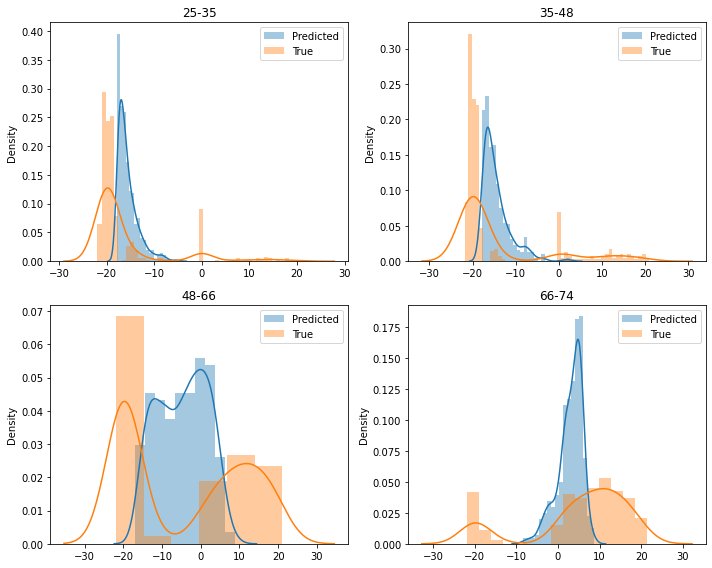

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
for i in range(4):
    age_index = (test_df["agegrp"].values == age_label[i])
    sns.distplot(y_pred_test[age_index], ax=ax[i], label = "Predicted")
    sns.distplot(y_test_con[age_index], ax=ax[i], label = "True")
    ax[i].set_title(age_label[i])
    ax[i].legend()

plt.tight_layout()

Model 3: Single Decision Tree Model with max_depth selected using cross validation

In [30]:
result = {}
for depth in range(1, 101, 5):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    tree.fit(x_train_orig_sca, y_train_con)
    cv = cross_val_score(tree, x_train_orig_sca, y_train_con, cv=5)
    result[depth] = np.mean(cv)
optimal_depth = min(result.keys(), key=lambda k: result[k])
print(optimal_depth)
best_tree = DecisionTreeRegressor(max_depth=optimal_depth)
best_tree.fit(x_train_orig_sca, y_train_con)
y_pred_test = best_tree.predict(x_test_orig_sca)
acc_test_best_tree = mean_squared_error(y_pred_test, y_test)
print("MSE is: " + str(round(acc_test_best_tree, 4)))

41
MSE is: 293.368


### 3. Models - Using Original Variables and Binary Output

Model 1: Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result_df = pd.DataFrame()
lr = LogisticRegression(penalty = 'none', max_iter=10000).fit(x_train_orig_sca, y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(x_train_orig_sca))
lr_test_acc = accuracy_score(y_test, lr.predict(x_test_orig_sca))
lr_test_auc = roc_auc_score(y_test,lr.predict(x_test_orig_sca))
lr_train_auc = roc_auc_score(y_train,lr.predict(x_train_orig_sca))
lr_fpr, lr_tpr,_=roc_curve(y_test,lr.predict_proba(x_test_orig_sca)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['logistic'],'test_auc':[lr_test_auc],'test_acc':[lr_test_acc],
                                           'test_fpr':[lr_fpr],'test_tpr':[lr_tpr]}),ignore_index=True)

print('Baseline logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('Baseline logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

Baseline logistic regression: accuracy on train set is  0.8297
Baseline logistic regression: accuracy on test set is  0.8349


In [32]:
result_df

,model,test_auc,test_acc,test_fpr,test_tpr
0,logistic,0.812896,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."


Model 2: Logistic Regression with L2 penalty

In [33]:
from sklearn.linear_model import LogisticRegression
lr_l2 = LogisticRegression(penalty = 'l2', max_iter=10000).fit(x_train_orig_sca, y_train)

lr_l2_train_acc = accuracy_score(y_train, lr_l2.predict(x_train_orig_sca))
lr_l2_test_acc = accuracy_score(y_test, lr_l2.predict(x_test_orig_sca))

lr_l2_test_auc = roc_auc_score(y_test,lr_l2.predict(x_test_orig_sca))
lr_l2_train_auc = roc_auc_score(y_train,lr_l2.predict(x_train_orig_sca))
lr_l2_fpr, lr_l2_tpr,_=roc_curve(y_test,lr_l2.predict_proba(x_test_orig_sca)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['logistic l2'],'test_auc':[lr_l2_test_auc],'test_acc':[lr_l2_test_acc],
                                           'test_fpr':[lr_l2_fpr],'test_tpr':[lr_l2_tpr]}),ignore_index=True)





In [34]:
print('Baseline logistic regression with L2 penalty: accuracy on train set is ', str(round(lr_l2_train_acc,4)))
print('Baseline logistic regression with L2 penalty: accuracy on test set is ', str(round(lr_l2_test_acc,4)))

Baseline logistic regression with L2 penalty: accuracy on train set is  0.8297
Baseline logistic regression with L2 penalty: accuracy on test set is  0.8354


Model 3: Logistic Regression with interaction terms

In [35]:
from sklearn.preprocessing import PolynomialFeatures

inters= PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
x_interaction_train = inters.fit_transform(x_train_orig_sca.copy())
x_interaction_train_df = pd.DataFrame(x_interaction_train,columns = inters.get_feature_names(x_train.columns))

x_interaction_test = inters.fit_transform(x_test_orig_sca.copy())
x_interaction_test_df = pd.DataFrame(x_interaction_test,columns= inters.get_feature_names(x_test.columns))

In [36]:
lr_inter = LogisticRegression(penalty = 'none',max_iter=10000).fit(x_interaction_train_df,y_train)

inter_train_acc = accuracy_score(y_train, lr_inter.predict(x_interaction_train_df))
inter_test_acc = accuracy_score(y_test, lr_inter.predict(x_interaction_test_df))

lr_inter_test_auc = roc_auc_score(y_test,lr_inter.predict(x_interaction_test_df))
lr_inter_train_auc = roc_auc_score(y_train,lr_inter.predict(x_interaction_train_df))
lr_inter_fpr, lr_inter_tpr,_=roc_curve(y_test,lr_inter.predict_proba(x_interaction_test_df)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['logistic interaction'],'test_auc':[lr_inter_test_auc],'test_acc':[inter_test_acc],
                                           'test_fpr':[lr_inter_fpr],'test_tpr':[lr_inter_tpr]}),ignore_index=True)



print('Logistic regression with interaction term: accuracy on train set is ', str(round(inter_train_acc,4)))
print('Logistic regression with interaction term: accuracy on test set is ', str(round(inter_test_acc,4)))

Logistic regression with interaction term: accuracy on train set is  0.8379
Logistic regression with interaction term: accuracy on test set is  0.8349


In [37]:
result_df.loc[2,'model']='logistic interaction'
result_df

,model,test_auc,test_acc,test_fpr,test_tpr
0,logistic,0.812896,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
1,logistic l2,0.813283,0.835430,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
2,logistic interaction,0.814225,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."


Model 4: Logistic Regression with polynomial terms

In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly= PolynomialFeatures(degree=3,include_bias=False)
x_poly_train = poly.fit_transform(x_train_orig_sca.copy())
x_poly_train_df = pd.DataFrame(x_poly_train,columns= poly.get_feature_names(x_train.columns))

x_poly_test = poly.fit_transform(x_test_orig_sca.copy())
x_poly_test_df = pd.DataFrame(x_poly_test,columns= poly.get_feature_names(x_test.columns))

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'none',max_iter=10000).fit(x_poly_train_df,y_train)

poly_train_acc = accuracy_score(y_train, lr.predict(x_poly_train_df))
poly_test_acc = accuracy_score(y_test, lr.predict(x_poly_test_df))

poly_test_auc = roc_auc_score(y_test,lr.predict(x_poly_test_df))
poly_train_auc = roc_auc_score(y_train,lr.predict(x_poly_train_df))
poly_fpr, poly_tpr,_=roc_curve(y_test,lr.predict_proba(x_poly_test_df)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['logistic polynomial(3)'],'test_auc':[poly_test_auc],'test_acc':[poly_test_acc],
                                           'test_fpr':[poly_fpr],'test_tpr':[poly_tpr]}),ignore_index=True)


print('Logistic regression with polynomial term: accuracy on train set is ', str(round(poly_train_acc,4)))
print('Logistic regression with polynomial term: accuracy on test set is ', str(round(poly_test_acc,4)))

Logistic regression with polynomial term: accuracy on train set is  0.8758
Logistic regression with polynomial term: accuracy on test set is  0.8067


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model 5: Logistic regression with polynomial term and L1 penalty

In [39]:
lr = LogisticRegression(penalty = 'l1',max_iter=10000,solver='liblinear').fit(x_poly_train_df,y_train)

poly_l1_train_acc = accuracy_score(y_train, lr.predict(x_poly_train_df))
poly_l1_test_acc = accuracy_score(y_test, lr.predict(x_poly_test_df))


poly_l1_test_auc = roc_auc_score(y_test,lr.predict(x_poly_test_df))
poly_l1_train_auc = roc_auc_score(y_train,lr.predict(x_poly_train_df))
poly_l1_fpr, poly_l1_tpr,_=roc_curve(y_test,lr.predict_proba(x_poly_test_df)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['logistic polynomial(3) l1'],'test_auc':[poly_l1_test_auc],'test_acc':[poly_l1_test_acc],
                                           'test_fpr':[poly_l1_fpr],'test_tpr':[poly_l1_tpr]}),ignore_index=True)




print('Logistic regression (L1 penalty) with polynomial term: accuracy on train set is ', str(round(poly_l1_train_acc,4)))
print('Logistic regression (L1 penalty) with polynomial term: accuracy on test set is ', str(round(poly_l1_test_acc,4)))

Logistic regression (L1 penalty) with polynomial term: accuracy on train set is  0.8719
Logistic regression (L1 penalty) with polynomial term: accuracy on test set is  0.8138


In [40]:
result_df

,model,test_auc,test_acc,test_fpr,test_tpr
0,logistic,0.812896,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
1,logistic l2,0.813283,0.835430,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
2,logistic interaction,0.814225,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
3,logistic polynomial(3),0.783578,0.806744,"[0.0, 0.0, 0.0, 0.0015479876160990713, 0.00154...","[0.0, 0.0028776978417266188, 0.010071942446043..."
4,logistic polynomial(3) l1,0.791655,0.813790,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.004316546762589..."


Model 6: Simple Decision Tree with max depth = 3

In [41]:
from sklearn.tree import DecisionTreeClassifier
tree0 = DecisionTreeClassifier(max_depth=3)
tree0.fit(x_train_orig_sca, y_train)
y_pred_test = tree0.predict(x_test_orig_sca)
y_pred_train = tree0.predict(x_train_orig_sca)
acc_test_tree = accuracy_score(y_test,y_pred_test)

acc_train_tree = accuracy_score(y_train,y_pred_train)

tree_test_auc = roc_auc_score(y_test,tree0.predict(x_test_orig_sca))
tree_train_auc = roc_auc_score(y_train,tree0.predict(x_train_orig_sca))
tree_fpr, tree_tpr,_=roc_curve(y_test,tree0.predict_proba(x_test_orig_sca)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['decision tree (depth=3)'],'test_auc':[tree_test_auc],'test_acc':[acc_test_tree],
                                           'test_fpr':[tree_fpr],'test_tpr':[tree_tpr]}),ignore_index=True)



print("Decision Tree accuracy in train set is: " + str(round(acc_train_tree, 4)))
print("Decision Tree accuracy in test set is: " + str(round(acc_test_tree, 4)))

Decision Tree accuracy in train set is: 0.8165
Decision Tree accuracy in test set is: 0.8264


In [42]:
result_df

,model,test_auc,test_acc,test_fpr,test_tpr
0,logistic,0.812896,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
1,logistic l2,0.813283,0.835430,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
2,logistic interaction,0.814225,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
3,logistic polynomial(3),0.783578,0.806744,"[0.0, 0.0, 0.0, 0.0015479876160990713, 0.00154...","[0.0, 0.0028776978417266188, 0.010071942446043..."
4,logistic polynomial(3) l1,0.791655,0.813790,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.004316546762589..."
5,decision tree (depth=3),0.810306,0.826371,"[0.0, 0.01934984520123839, 0.04411764705882353...","[0.0, 0.20575539568345325, 0.38273381294964026..."


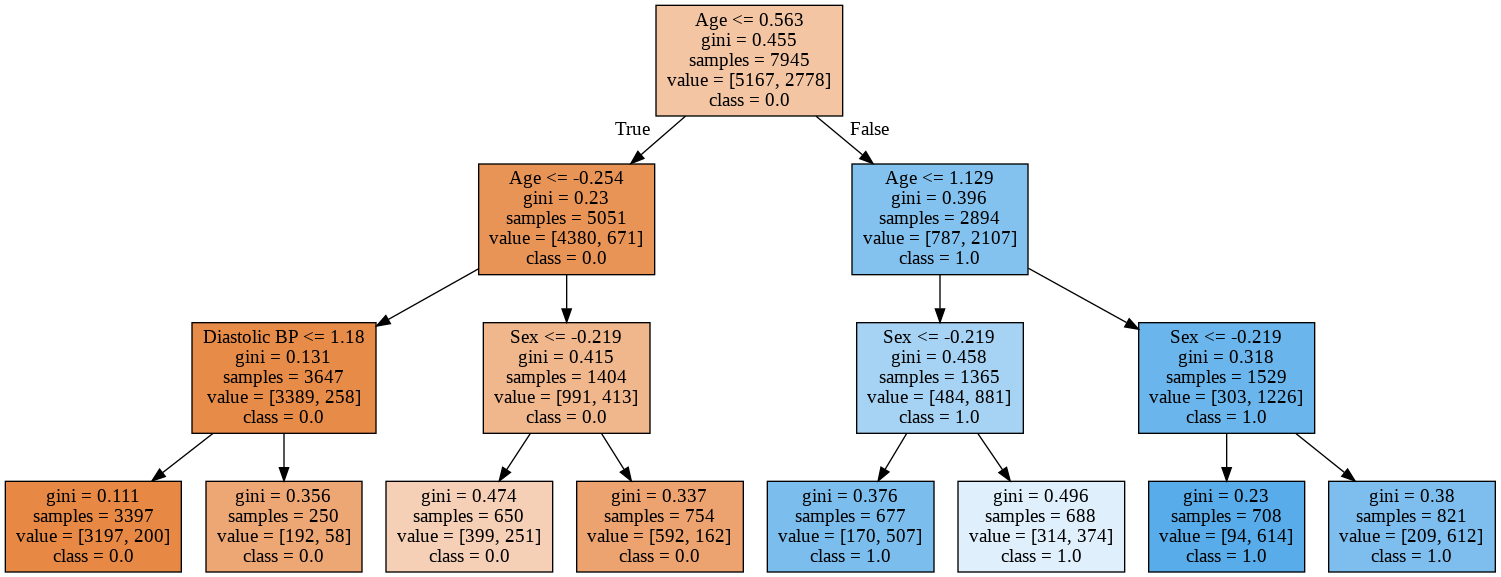

In [43]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dt_feature_names = list(x_train.columns)
dt_target_names = [str(s) for s in y_train.unique()]
tree.export_graphviz(tree0, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Model 7: GBDT Model using LightGBM framework with training and evaluation dataset

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_orig_sca, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train.columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)
y_pred_train = model2.predict(x_train_orig_sca, num_iteration=model2.best_iteration)
y_pred_lgb_train = y_pred_train.round(0)
acc_lgb_train = accuracy_score(y_train, y_pred_lgb_train)

y_pred_test = model2.predict(x_test_orig_sca, num_iteration=model2.best_iteration)
y_pred_lgb_test = y_pred_test.round(0)
acc_lgb_test = accuracy_score(y_test, y_pred_lgb_test)

lgb_test_auc = roc_auc_score(y_test,y_pred_lgb_test)
lgb_train_auc = roc_auc_score(y_train,y_pred_lgb_train)
lgb_fpr, lgb_tpr,_=roc_curve(y_test,y_pred_test)

result_df = result_df.append(pd.DataFrame({'model':['lightgbm'],'test_auc':[lgb_test_auc],'test_acc':[acc_lgb_test],
                                         'test_fpr':[lgb_fpr],'test_tpr':[lgb_tpr]}),ignore_index=True)




print("Accuracy in train set is: " + str(round(acc_lgb_train, 4)))
print("Accuracy in test set is: " + str(round(acc_lgb_test, 4)))

Accuracy in train set is: 0.8623
Accuracy in test set is: 0.8415


Text(0, 0.5, 'Features')

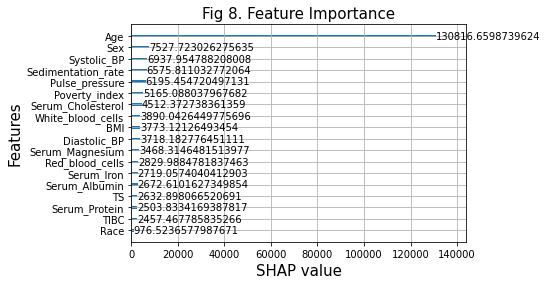

In [45]:
lgb.plot_importance(model2, importance_type="gain")
plt.title('Fig 8. Feature Importance',fontsize = 15)
plt.xlabel('SHAP value',fontsize=15)
plt.ylabel('Features',fontsize=15)

In [46]:
!pip install shap

In [47]:
import shap
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(x_train_orig_sca)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### 3.3 SHAP Plots

_summary plot_

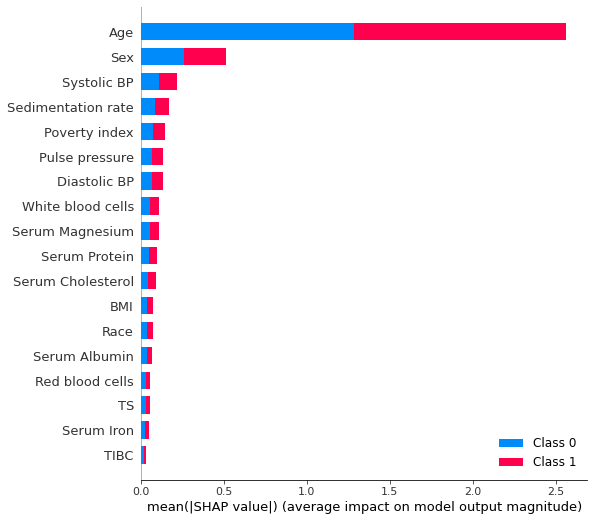

In [48]:
shap.summary_plot(shap_values, x_train_orig_sca, plot_type="bar", feature_names=x_train.columns)

_Interaction value_

In [49]:
shap_interaction_values = shap.TreeExplainer(model2).shap_interaction_values(x_train_orig_sca)

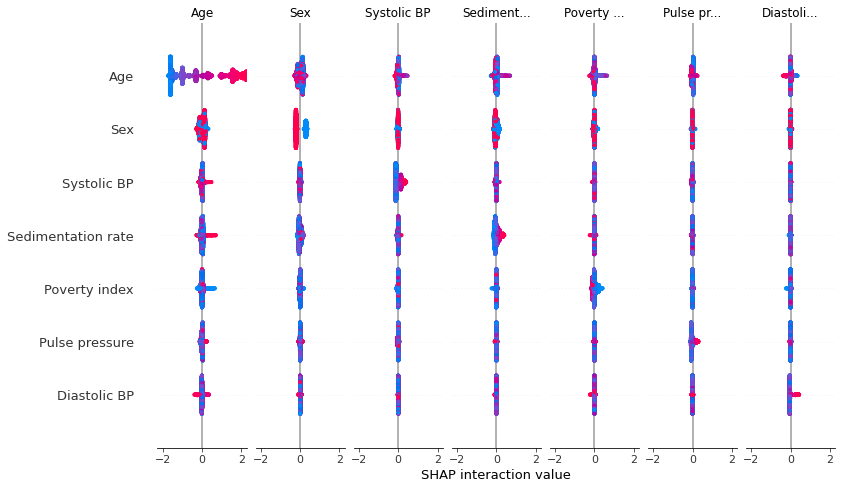

In [50]:
shap.summary_plot(shap_interaction_values,x_train_orig_sca,feature_names=x_train.columns)

_Systolic BP and Age_

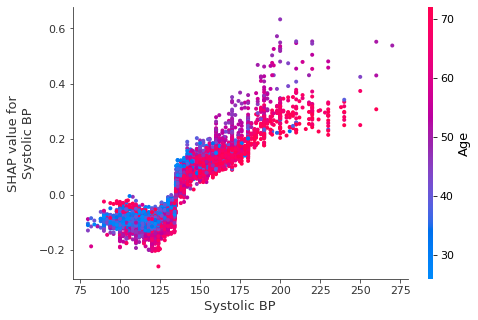

In [51]:
shap.dependence_plot("Systolic BP", shap_values[1], x_train_orig, interaction_index='Age',feature_names=x_train.columns)

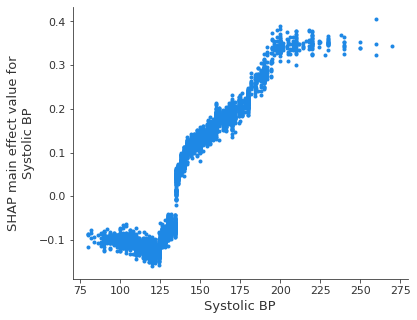

In [52]:
shap.dependence_plot(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, x_train_orig, interaction_index = None, feature_names=x_train.columns
)

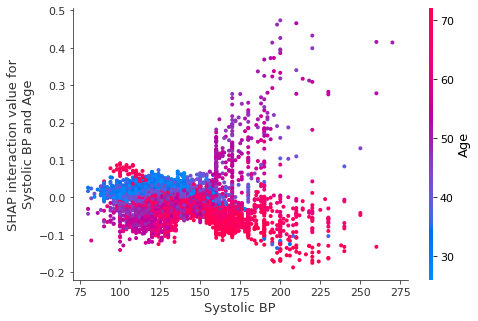

In [53]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, x_train_orig, feature_names=x_train.columns
)

_Sex and Sedimentation rate_

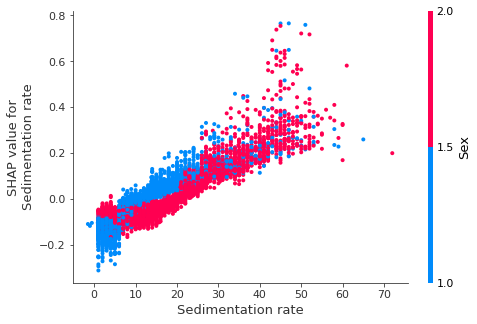

In [54]:
shap.dependence_plot("Sedimentation rate", shap_values[1], x_train_orig, interaction_index='Sex',feature_names=x_train.columns)

_Age and Sex_

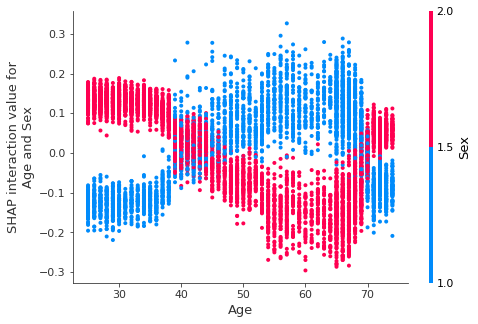

In [55]:
shap.dependence_plot(
    ("Age","Sex"),
    shap_interaction_values, x_train_orig, feature_names=x_train.columns
)

_Sedimentation rate and Age_

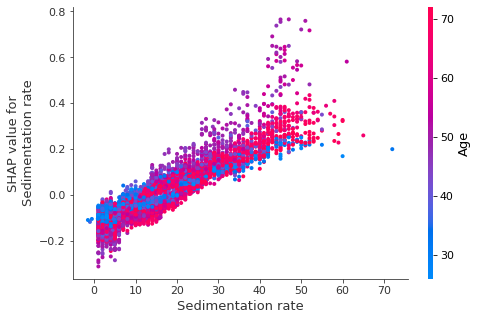

In [56]:
shap.dependence_plot("Sedimentation rate", shap_values[1], x_train_orig, interaction_index='Age',feature_names=x_train.columns)

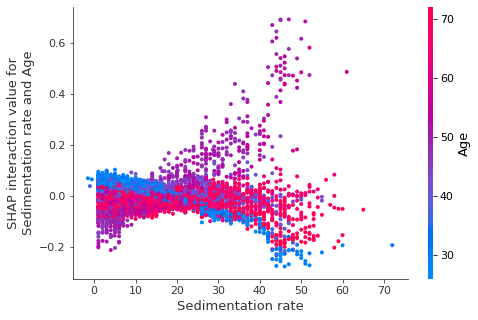

In [57]:
shap.dependence_plot(
    ("Sedimentation rate","Age"),
    shap_interaction_values, x_train_orig, feature_names=x_train.columns
)

_Sex and Systolic BP_

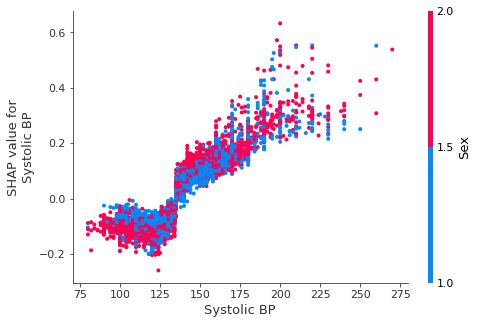

In [58]:
shap.dependence_plot("Systolic BP", shap_values[1], x_train_orig, interaction_index='Sex',feature_names=x_train.columns)

_Systolic BP and Sedimentation rate_

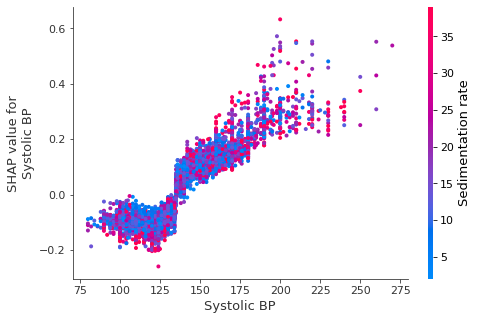

In [59]:
shap.dependence_plot("Systolic BP", shap_values[1], x_train_orig, interaction_index='Sedimentation rate',feature_names=x_train.columns)

Model building continued: Model 8: Random Forest

In [60]:
np.random.seed(109)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 8, 10],
    'max_features': [2, 3,5,10],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(x_train_orig_sca, y_train)
grid_search.best_params_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  8.7min finished


{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'n_estimators': 500}

In [61]:
np.random.seed(109)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10)
rf.fit(x_train_orig_sca,y_train);
rf_pred_train = rf.predict(x_train_orig_sca)
rf_pred_test = rf.predict(x_test_orig_sca)
acc_rf_test = accuracy_score(y_test, rf_pred_test)
acc_rf_train = accuracy_score(y_train,rf_pred_train)

rf_test_auc = roc_auc_score(y_test,rf_pred_test)
rf_train_auc = roc_auc_score(y_train,rf_pred_train)
rf_fpr, rf_tpr,_=roc_curve(y_test,rf.predict_proba(x_test_orig_sca)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['randomforest'],'test_auc':[rf_test_auc],'test_acc':[acc_rf_test],
                                         'test_fpr':[rf_fpr],'test_tpr':[rf_tpr]}),ignore_index=True)




print('Random Forest model: Accuracy on train set is ',str(round(acc_rf_train,4)))
print('Random Forest model: Accuracy on test set is ',str(round(acc_rf_test,4)))

Random Forest model: Accuracy on train set is  0.9093
Random Forest model: Accuracy on test set is  0.8359


In [62]:
#!pip install eli5
result_df

,model,test_auc,test_acc,test_fpr,test_tpr
0,logistic,0.812896,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
1,logistic l2,0.813283,0.835430,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
2,logistic interaction,0.814225,0.834927,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.014388489208633..."
3,logistic polynomial(3),0.783578,0.806744,"[0.0, 0.0, 0.0, 0.0015479876160990713, 0.00154...","[0.0, 0.0028776978417266188, 0.010071942446043..."
4,logistic polynomial(3) l1,0.791655,0.813790,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.004316546762589..."
5,decision tree (depth=3),0.810306,0.826371,"[0.0, 0.01934984520123839, 0.04411764705882353...","[0.0, 0.20575539568345325, 0.38273381294964026..."
6,lightgbm,0.819921,0.841470,"[0.0, 0.0, 0.0, 0.0007739938080495357, 0.00077...","[0.0, 0.0014388489208633094, 0.012949640287769..."
7,randomforest,0.817991,0.835934,"[0.0, 0.0, 0.0, 0.0015479876160990713, 0.00154...","[0.0, 0.0014388489208633094, 0.002877697841726..."


In [63]:
!pip install eli5

Model 9: Adaboost with baseline decision tree model (max depth = 3) as base classifier

In [64]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=1000,
    learning_rate=.1)
adaboost.fit(x_train_orig_sca,y_train)
ada_pred_train = adaboost.predict(x_train_orig_sca)
ada_pred_test = adaboost.predict(x_test_orig_sca)
acc_ada_train = accuracy_score(y_train,ada_pred_train)
acc_ada_test = accuracy_score(y_test,ada_pred_test)

ada_test_auc = roc_auc_score(y_test,ada_pred_test)
ada_train_auc = roc_auc_score(y_train,ada_pred_train)
ada_fpr, ada_tpr,_=roc_curve(y_test,adaboost.predict_proba(x_test_orig_sca)[:,1])

result_df = result_df.append(pd.DataFrame({'model':['adaboost'],'test_auc':[ada_test_auc],'test_acc':[acc_ada_test],
                                         'test_fpr':[ada_fpr],'test_tpr':[ada_tpr]}),ignore_index=True)

print('Adaboost model: Accuracy on train set is ',str(round(acc_ada_train,4)))
print('Adaboost model: Accuracy on test set is ',str(round(acc_ada_test,4)))

Adaboost model: Accuracy on train set is  0.9563
Adaboost model: Accuracy on test set is  0.8103


Model 10: LSTM Model

In [65]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [66]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=150, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape = (None, x_train_orig_sca.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(64, activation='relu', input_shape = (None, x_train_orig_sca.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences = True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')]
)
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
filename = "best_model2.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

X_train = np.reshape(np.array(x_train_orig_sca), (x_train_orig_sca.shape[0], 1, x_train_orig_sca.shape[1]))
hist = model_lstm.fit(X_train, y_train, batch_size = 256, epochs = 1000, validation_split=0.2, callbacks=[checkpoint, callback])

Epoch 1/1000
25/25 [==============================] - 1s 34ms/step - loss: 0.6893 - accuracy: 0.6517 - val_loss: 0.6849 - val_accuracy: 0.6451
Epoch 2/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.6703 - accuracy: 0.6517 - val_loss: 0.6297 - val_accuracy: 0.6451
Epoch 3/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.5586 - accuracy: 0.6518 - val_loss: 0.5059 - val_accuracy: 0.6463
Epoch 4/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.4996 - accuracy: 0.7245 - val_loss: 0.4566 - val_accuracy: 0.7961
Epoch 5/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.4430 - accuracy: 0.8107 - val_loss: 0.4257 - val_accuracy: 0.8074
Epoch 6/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.4182 - accuracy: 0.8172 - val_loss: 0.4133 - val_accuracy: 0.8037
Epoch 7/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.4041 - accuracy: 0.8241 - val_loss: 0.4075 - val_accuracy: 0.8125

In [67]:
model_lstm.load_weights("best_model2.h5")
X_test = np.reshape(np.array(x_test_orig_sca), (x_test_orig_sca.shape[0], 1, x_test_orig_sca.shape[1]))
lstm_pred = model_lstm.predict_classes(X_test)
acc_lstm_test=accuracy_score(y_test,lstm_pred)


lstm_test_auc = roc_auc_score(y_test,lstm_pred)
#lgb_train_auc = roc_auc_score(y_train,y_pred_lgb_train)
lstm_fpr, lstm_tpr,_=roc_curve(y_test,model_lstm.predict(X_test))

result_df = result_df.append(pd.DataFrame({'model':['lstm'],'test_auc':[lstm_test_auc],'test_acc':[acc_lstm_test],
                                         'test_fpr':[lstm_fpr],'test_tpr':[lstm_tpr]}),ignore_index=True)





Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


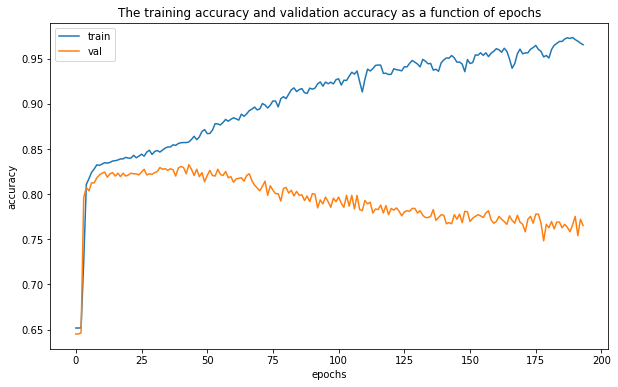

In [68]:
plt.figure(figsize=(10,6))
plt.plot(list(range(len(hist.history['accuracy']))), hist.history['accuracy'], label = 'train')
plt.plot(list(range(len(hist.history['accuracy']))), hist.history['val_accuracy'], label = 'val')
plt.title('The training accuracy and validation accuracy as a function of epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

#### 3.2 Model comparison 

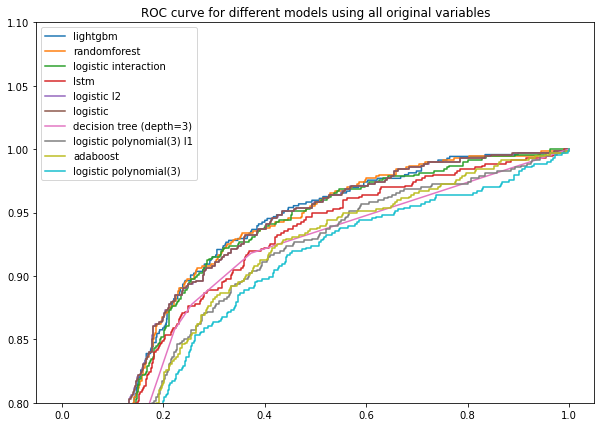

In [69]:
import matplotlib.pyplot as plt
result_df_plot = pd.DataFrame(result_df.sort_values(by=['test_auc'],ascending=False)[:10])
plt.figure(figsize=(10, 7))
for i in range(result_df_plot.shape[0]):
    plt.plot(result_df_plot.iloc[i,3],result_df_plot.iloc[i,4],label=result_df_plot.iloc[i,0])
plt.ylim(0.8,1.1)
plt.title('ROC curve for different models using all original variables')
plt.legend(loc='best')

In [70]:
result_df[['model','test_acc','test_auc']].sort_values(by=['test_acc'],ascending=False)

,model,test_acc,test_auc
6,lightgbm,0.841470,0.819921
7,randomforest,0.835934,0.817991
1,logistic l2,0.835430,0.813283
0,logistic,0.834927,0.812896
2,logistic interaction,0.834927,0.814225
9,lstm,0.827378,0.813407
5,decision tree (depth=3),0.826371,0.810306
4,logistic polynomial(3) l1,0.813790,0.791655
8,adaboost,0.810267,0.783960
3,logistic polynomial(3),0.806744,0.783578


### 4. Feature Selection Part

In [71]:
variable_drop = []
accs_train_gbm = []
accs_test_gbm = []
accs_train_logis = []
accs_test_logis = []
accs_train_logis_l2 = []
accs_test_logis_l2 = []

for i in range(18):
    print(i)
    df_temp_train = pd.DataFrame(x_train_orig_sca.copy(), columns = data.columns[:18])
    df_temp_test = pd.DataFrame(x_test_orig_sca.copy(), columns = data.columns[:18])
    if i > 0:
        x_train_feature = df_temp_train.drop(variable_drop, axis=1)
        x_test_feature = df_temp_test.drop(variable_drop, axis=1)
    else:
        x_train_feature = df_temp_train.copy()
        x_test_feature = df_temp_test.copy()
    x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_feature, y_train, train_size=0.85, random_state=1)
    params = {
      'boosting_type': 'gbdt',
      'objective': 'binary',
      'learning_rate': 0.01,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
      'bagging_freq': 5,
      'max_depth': 100,
      'seed': 1
    }
    lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train_feature.columns))
    lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train_feature.columns))
    model_fea = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                  valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)
    y_pred_train = model_fea.predict(x_train_feature, num_iteration=model_fea.best_iteration)
    y_pred_lgb_train = y_pred_train.round(0)
    acc_lgb_train = accuracy_score(y_train, y_pred_lgb_train)

    y_pred_test = model_fea.predict(x_test_feature, num_iteration=model_fea.best_iteration)
    y_pred_lgb_test = y_pred_test.round(0)
    acc_lgb_test = accuracy_score(y_test, y_pred_lgb_test)
    accs_train_gbm.append(acc_lgb_train)
    accs_test_gbm.append(acc_lgb_test)
    lr = LogisticRegression(penalty = 'l2', max_iter=10000).fit(x_train_feature, y_train)
    accs_train_logis_l2.append(accuracy_score(y_train, lr.predict(x_train_feature)))
    accs_test_logis_l2.append(accuracy_score(y_test, lr.predict(x_test_feature)))

    lr = LogisticRegression(penalty = 'none', max_iter=10000).fit(x_train_feature, y_train)
    accs_train_logis.append(accuracy_score(y_train, lr.predict(x_train_feature)))
    accs_test_logis.append(accuracy_score(y_test, lr.predict(x_test_feature)))

    # drop
    explainer = shap.TreeExplainer(model_fea)
    shap_values = explainer.shap_values(x_train_feature)
    mean_shap_feature_values = pd.DataFrame(shap_values[0], 
                                          columns=x_train_feature.columns).abs().mean(axis=0).sort_values(ascending=False)
    variable_drop.append(list(mean_shap_feature_values.index)[-1])

0


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


3


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


4


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


6


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


7


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


8


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


9


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


10


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


11


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


12


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


13


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


14


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


15


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


16


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


17


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


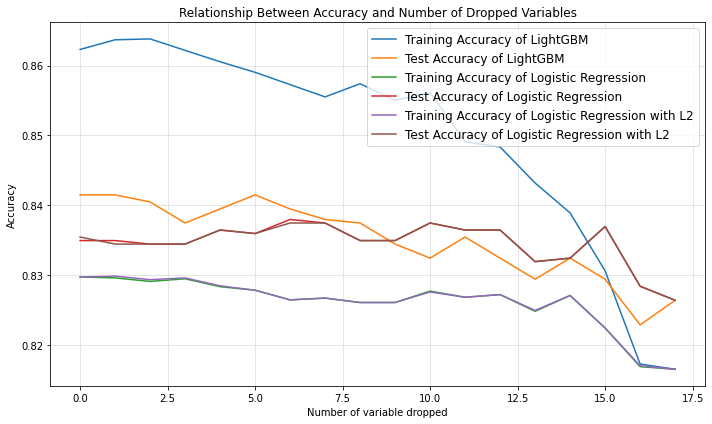

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(accs_train_gbm)), accs_train_gbm, label="Training Accuracy of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_test_gbm, label="Test Accuracy of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_train_logis, label="Training Accuracy of Logistic Regression")
ax.plot(range(len(accs_train_gbm)), accs_test_logis, label="Test Accuracy of Logistic Regression")
ax.plot(range(len(accs_train_gbm)), accs_train_logis_l2, label="Training Accuracy of Logistic Regression with L2")
ax.plot(range(len(accs_train_gbm)), accs_test_logis_l2, label="Test Accuracy of Logistic Regression with L2")
plt.legend(fontsize=12)
plt.xlabel("Number of variable dropped")
plt.ylabel("Accuracy")
plt.title("Relationship Between Accuracy and Number of Dropped Variables")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

If there is just one variable "Age"

In [73]:
df_temp_train = pd.DataFrame(x_train_orig_sca, columns = data.columns[:18])
df_temp_test = pd.DataFrame(x_test_orig_sca, columns = data.columns[:18])
lr = LogisticRegression(penalty = 'none', max_iter=10000).fit(df_temp_train[["Age"]].values, y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(df_temp_train[["Age"]].values))
lr_test_acc = accuracy_score(y_test, lr.predict(df_temp_test[["Age"]].values))
print('logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

logistic regression: accuracy on train set is  0.8165
logistic regression: accuracy on test set is  0.8264


In [74]:
lr = LogisticRegression(penalty = 'l2', max_iter=10000).fit(df_temp_train[["Age"]].values, y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(df_temp_train[["Age"]].values))
lr_test_acc = accuracy_score(y_test, lr.predict(df_temp_test[["Age"]].values))
print('logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

logistic regression: accuracy on train set is  0.8165
logistic regression: accuracy on test set is  0.8264


In [75]:
x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(df_temp_train[["Age"]].values, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=["Age"])
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=["Age"])
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)
y_pred_train = model2.predict(df_temp_train[["Age"]].values, num_iteration=model2.best_iteration)
y_pred_lgb_train = y_pred_train.round(0)
acc_lgb_train = accuracy_score(y_train, y_pred_lgb_train)

y_pred_test = model2.predict(df_temp_test[["Age"]].values, num_iteration=model2.best_iteration)
y_pred_lgb_test = y_pred_test.round(0)
acc_lgb_test = accuracy_score(y_test, y_pred_lgb_test)

print("Accuracy in train set is: " + str(round(acc_lgb_train, 4)))
print("Accuracy in test set is: " + str(round(acc_lgb_test, 4)))

Accuracy in train set is: 0.8165
Accuracy in test set is: 0.8264


Final Selection: 4 variables (Age, Sex, Systolic BP, Sedimentation rate)

In [76]:
final_select = ["Systolic BP", "Sedimentation rate", "Age", "Sex"]

In [77]:
df_temp_train = pd.DataFrame(x_train_orig_sca.copy(), columns = data.columns[:18])
final_df_train = df_temp_train[final_select]
df_temp_test = pd.DataFrame(x_test_orig_sca.copy(), columns = data.columns[:18])
final_df_test = df_temp_test[final_select]

In [78]:
lr = LogisticRegression(penalty = 'none', max_iter=10000).fit(final_df_train.values, y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(final_df_train.values))
lr_test_acc = accuracy_score(y_test, lr.predict(final_df_test.values))
print('logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

logistic regression: accuracy on train set is  0.8271
logistic regression: accuracy on test set is  0.8324


In [79]:
x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(final_df_train.values, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(final_df_train.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(final_df_train.columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)
y_pred_train = model2.predict(final_df_train.values, num_iteration=model2.best_iteration)
y_pred_lgb_train = y_pred_train.round(0)
acc_lgb_train = accuracy_score(y_train, y_pred_lgb_train)

y_pred_test = model2.predict(final_df_test.values, num_iteration=model2.best_iteration)
y_pred_lgb_test = y_pred_test.round(0)
acc_lgb_test = accuracy_score(y_test, y_pred_lgb_test)

print("Accuracy in train set is: " + str(round(acc_lgb_train, 4)))
print("Accuracy in test set is: " + str(round(acc_lgb_test, 4)))

Accuracy in train set is: 0.8409
Accuracy in test set is: 0.8324


Step of choosing 4 variables

In [80]:
variable_drop = []
freq = {}

for i in range(15):
    df_temp_train = pd.DataFrame(x_train_orig_sca.copy(), columns = data.columns[:18])
    df_temp_test = pd.DataFrame(x_test_orig_sca.copy(), columns = data.columns[:18])
    if i > 0:
        x_train_feature = df_temp_train.drop(variable_drop, axis=1)
        x_test_feature = df_temp_test.drop(variable_drop, axis=1)
    else:
        x_train_feature = df_temp_train.copy()
        x_test_feature = df_temp_test.copy()
    x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_feature, y_train, train_size=0.85, random_state=1)
    params = {
      'boosting_type': 'gbdt',
      'objective': 'binary',
      'learning_rate': 0.01,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
      'bagging_freq': 5,
      'max_depth': 100,
      'seed': 1
    }
    lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train_feature.columns))
    lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train_feature.columns))
    model_fea = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                  valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=False)
    y_pred_train = model_fea.predict(x_train_feature, num_iteration=model_fea.best_iteration)

    # drop
    explainer = shap.TreeExplainer(model_fea)
    shap_values = explainer.shap_values(x_train_feature)
    mean_shap_feature_values = pd.DataFrame(shap_values[0], 
                                          columns=x_train_feature.columns).abs().mean(axis=0).sort_values(ascending=False)
    variable_drop.append(list(mean_shap_feature_values.index)[-1])
    for element in list(mean_shap_feature_values.index)[:4]:
        if element not in freq:
            freq[element] = 1
        else:
            freq[element] += 1

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [81]:
print(freq)

{'Age': 15, 'Sex': 15, 'Systolic BP': 15, 'Sedimentation rate': 12, 'Poverty index': 3}


### 5. Models - Using Self-defined Binary Variables

> Baseline Model 0: Logistic Regression


In [82]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'none',max_iter=10000).fit(x_train_dummy_norm,y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(x_train_dummy_norm))
lr_test_acc = accuracy_score(y_test, lr.predict(x_test_dummy_norm))
print('Baseline logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('Baseline logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

Baseline logistic regression: accuracy on train set is  0.8159
Baseline logistic regression: accuracy on test set is  0.8067


In [83]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l2', max_iter=10000).fit(x_train_dummy_norm,y_train)

lr_train_acc = accuracy_score(y_train, lr.predict(x_train_dummy_norm))
lr_test_acc = accuracy_score(y_test, lr.predict(x_test_dummy_norm))
print('Baseline logistic regression: accuracy on train set is ', str(round(lr_train_acc,4)))
print('Baseline logistic regression: accuracy on test set is ', str(round(lr_test_acc,4)))

Baseline logistic regression: accuracy on train set is  0.8164
Baseline logistic regression: accuracy on test set is  0.8088


Logistic Regression with interaction terms

In [84]:
print(x_train_dummy_norm.columns)

Index(['Age_Middle Age', 'Age_Elder', 'Diastolic BP_High',
       'Diastolic BP_Hyper', 'Systolic BP_High', 'Systolic BP_Hyper',
       'Pulse pressure_Normal', 'Pulse pressure_High',
       'Sedimentation rate_Median', 'Sedimentation rate_High',
       'Serum Cholesterol_Abnormal', 'Sex_Male', 'Race_Other', 'Race_White',
       'Poverty index', 'Red blood cells', 'Serum Albumin', 'Serum Iron',
       'Serum Magnesium', 'Serum Protein', 'TIBC', 'TS', 'White blood cells',
       'BMI'],
      dtype='object')


In [85]:
from sklearn.preprocessing import PolynomialFeatures

inters= PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
x_interaction_train = inters.fit_transform(x_train_dummy_norm)
x_interaction_train_df = pd.DataFrame(x_interaction_train,columns= inters.get_feature_names(x_train_dummy_norm.columns))

x_interaction_test = inters.fit_transform(x_test_dummy_norm)
x_interaction_test_df = pd.DataFrame(x_interaction_test,columns= inters.get_feature_names(x_test_dummy_norm.columns))



In [86]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'none',max_iter=10000).fit(x_interaction_train_df,y_train)

inter_train_acc = accuracy_score(y_train, lr.predict(x_interaction_train_df))
inter_test_acc = accuracy_score(y_test, lr.predict(x_interaction_test_df))
print('Logistic regression with interaction term: accuracy on train set is ', str(round(inter_train_acc,4)))
print('Logistic regression with interaction term: accuracy on test set is ', str(round(inter_test_acc,4)))

Logistic regression with interaction term: accuracy on train set is  0.8276
Logistic regression with interaction term: accuracy on test set is  0.8098


Logistic Regression with polynomial terms

In [87]:
from sklearn.preprocessing import PolynomialFeatures

poly= PolynomialFeatures(degree=3,include_bias=False)
x_poly_train = poly.fit_transform(x_train_dummy_norm)
x_poly_train_df = pd.DataFrame(x_poly_train,columns= poly.get_feature_names(x_train_dummy_norm.columns))

x_poly_test = poly.fit_transform(x_test_dummy_norm)
x_poly_test_df = pd.DataFrame(x_poly_test,columns= poly.get_feature_names(x_test_dummy_norm.columns))

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'none',max_iter=10000).fit(x_poly_train_df,y_train)

poly_train_acc = accuracy_score(y_train, lr.predict(x_poly_train_df))
poly_test_acc = accuracy_score(y_test, lr.predict(x_poly_test_df))
print('Logistic regression with polynomial term: accuracy on train set is ', str(round(poly_train_acc,4)))
print('Logistic regression with polynomial term: accuracy on test set is ', str(round(poly_test_acc,4)))


Logistic regression with polynomial term: accuracy on train set is  0.9144
Logistic regression with polynomial term: accuracy on test set is  0.7519


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [88]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1',max_iter=10000,solver='liblinear').fit(x_poly_train_df,y_train)

poly_train_acc = accuracy_score(y_train, lr.predict(x_poly_train_df))
poly_test_acc = accuracy_score(y_test, lr.predict(x_poly_test_df))
print('Logistic regression (L1 penalty) with polynomial term: accuracy on train set is ', str(round(poly_train_acc,4)))
print('Logistic regression (L1 penalty) with polynomial term: accuracy on test set is ', str(round(poly_test_acc,4)))

Logistic regression (L1 penalty) with polynomial term: accuracy on train set is  0.8828
Logistic regression (L1 penalty) with polynomial term: accuracy on test set is  0.7861


> Model 1: Simple Decision Tree with max depth = 3

In [89]:
from sklearn.tree import DecisionTreeClassifier
tree0 = DecisionTreeClassifier(max_depth=3)
tree0.fit(x_train_dummy_norm, y_train)
y_pred_test = tree0.predict(x_test_dummy_norm)
y_pred_train = tree0.predict(x_train_dummy_norm)
acc_test_dtree = accuracy_score(y_test,y_pred_test)

acc_train_dtree = accuracy_score(y_train,y_pred_train)

print("Decision Tree accuracy in train set is: " + str(round(acc_train_dtree, 4)))
print("Decision Tree accuracy in test set is: " + str(round(acc_test_dtree, 4)))
#lr = LogisticRegression(penalty = 'none').fit(xx,y_train)
#lr_train_acc = accuracy_score(y_train, lr.predict(x_train_dummy))
#lr_test_acc = accuracy_score(y_test, lr.predict(x_test_dummy))
#print('Baseline logistic regression: accuracy on test data is ', str(round(lr_test_acc,4)))

Decision Tree accuracy in train set is: 0.7967
Decision Tree accuracy in test set is: 0.7992


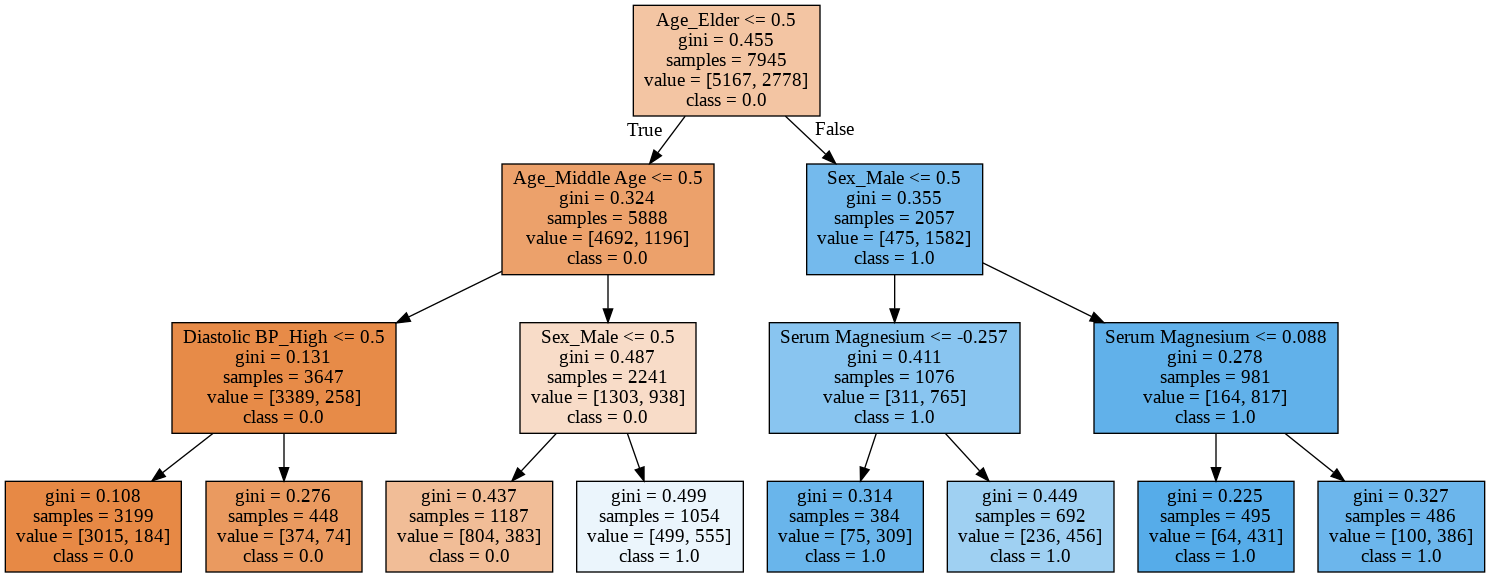

In [90]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dt_feature_names = list(x_train_dummy.columns)
dt_target_names = [str(s) for s in y_train.unique()]
tree.export_graphviz(tree0, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())


> Model 2: GBDT Model using LightGBM framework with training and evaluation dataset

In [91]:
x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_dummy_norm, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train_dummy_norm.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train_dummy_norm.columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1000, verbose_eval=True)
y_pred_train = model2.predict(x_train_dummy_norm, num_iteration=model2.best_iteration)
y_pred_lgb_train = y_pred_train.round(0)
acc_lgb_train = accuracy_score(y_train, y_pred_lgb_train)

y_pred_test = model2.predict(x_test_dummy_norm, num_iteration=model2.best_iteration)
y_pred_lgb_test = y_pred_test.round(0)
acc_lgb_test = accuracy_score(y_test, y_pred_lgb_test)
print("Accuracy in train set is: " + str(round(acc_lgb_train, 4)))
print("Accuracy in test set is: " + str(round(acc_lgb_test, 4)))

[1]	train's binary_logloss: 0.644246	eval's binary_logloss: 0.635164
Training until validation scores don't improve for 1000 rounds.
[2]	train's binary_logloss: 0.639914	eval's binary_logloss: 0.631296
[3]	train's binary_logloss: 0.6361	eval's binary_logloss: 0.627881
[4]	train's binary_logloss: 0.631945	eval's binary_logloss: 0.624247
[5]	train's binary_logloss: 0.627867	eval's binary_logloss: 0.620601
[6]	train's binary_logloss: 0.623957	eval's binary_logloss: 0.617111
[7]	train's binary_logloss: 0.620143	eval's binary_logloss: 0.613723
[8]	train's binary_logloss: 0.61679	eval's binary_logloss: 0.610776
[9]	train's binary_logloss: 0.614597	eval's binary_logloss: 0.60906
[10]	train's binary_logloss: 0.610934	eval's binary_logloss: 0.605852
[11]	train's binary_logloss: 0.607435	eval's binary_logloss: 0.602877
[12]	train's binary_logloss: 0.604256	eval's binary_logloss: 0.600113
[13]	train's binary_logloss: 0.602029	eval's binary_logloss: 0.598238
[14]	train's binary_logloss: 0.598559	e

Text(0, 0.5, 'Features')

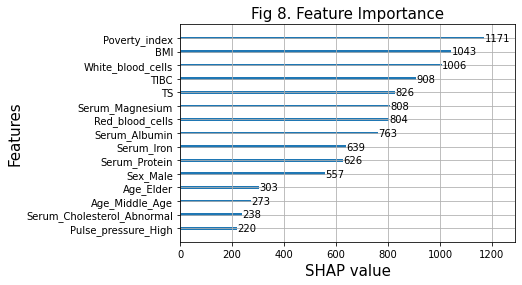

In [92]:
lgb.plot_importance(model2 ,max_num_features=15)
plt.title('Fig 8. Feature Importance',fontsize = 15)
plt.xlabel('SHAP value',fontsize=15)
plt.ylabel('Features',fontsize=15)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [94]:
best_rf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features = 20)
best_rf.fit(x_train_dummy_norm,y_train);
rf_pred_train = best_rf.predict(x_train_dummy_norm)
rf_pred_test = best_rf.predict(x_test_dummy_norm)
acc_best_rf_test = accuracy_score(y_test, rf_pred_test)
acc_best_rf_train = accuracy_score(y_train,rf_pred_train)
print('Random Forest model: Accuracy on train set is ',str(round(acc_best_rf_train,4)))
print('Random Forest model: Accuracy on test set is ',str(round(acc_best_rf_test,4)))


Random Forest model: Accuracy on train set is  0.9129
Random Forest model: Accuracy on test set is  0.8218


> Model 3: RandomForest

Text(0.5, 1.0, 'Relative Variable Importance for rf')

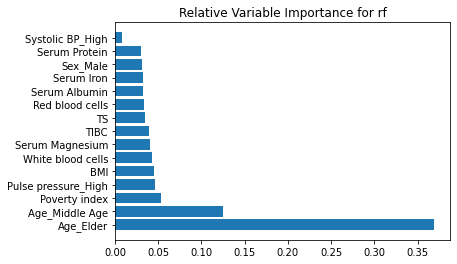

In [95]:
num=15
rf_importances = best_rf.feature_importances_
order = np.flip(np.argsort(rf_importances))[0:num]
plt.barh(range(num),rf_importances[order],tick_label=x_train_dummy_norm.columns[order]);
plt.title("Relative Variable Importance for rf")

In [96]:
np.random.seed(109)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 8, 10],
    'max_features': [2, 3,5,10],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
#randomforest = RandomForestClassifier(n_estimators=100, max_depth=10)
#randomforest.fit(x_train_dummy,y_train);
grid_search.fit(x_train_dummy_norm, y_train)
grid_search.best_params_
#adaboost = AdaBoostClassifier(
 #   base_estimator=DecisionTreeClassifier(max_depth=4),
 #   n_estimators=1000,
  #  learning_rate=.8)
#adaboost.fit(X_train,y_train);
#rf_test_pred_dummy = randomforest.predict(x_test_dummy)
#accuracy_score(y_test,rf_test_pred_dummy)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.2min finished


{'bootstrap': True, 'max_depth': 8, 'max_features': 10, 'n_estimators': 500}

In [97]:
import eli5
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(best_rf,random_state=seed,n_iter=10).fit(x_test_dummy_norm, y_test)
eli5.show_weights(perm,feature_names=x_test_dummy_norm.columns.tolist())

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


Weight,Feature
0.2232 ± 0.0237,Age_Elder
0.0253 ± 0.0051,Age_Middle Age
0.0245 ± 0.0094,Sex_Male
0.0119 ± 0.0058,Pulse pressure_High
0.0061 ± 0.0052,Poverty index
0.0054 ± 0.0057,White blood cells
0.0038 ± 0.0049,Serum Albumin
0.0025 ± 0.0017,Sedimentation rate_High
0.0022 ± 0.0048,Serum Protein
0.0021 ± 0.0021,Sedimentation rate_Median


>> SHAP Interpretation of the best random forest model

In [98]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(x_train_dummy_norm)

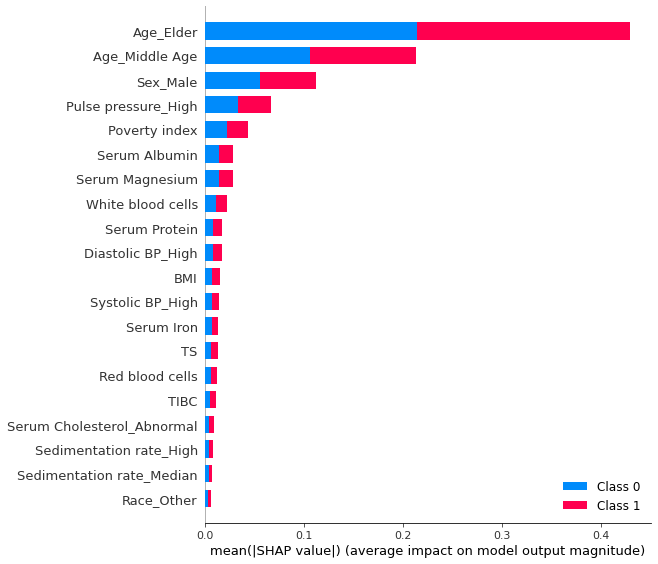

In [99]:
shap.summary_plot(shap_values, x_train_dummy_norm)


In [100]:
#shap.force_plot(explainer.expected_value, shap_values[0][:], x_train_dummy_norm.iloc[0,:], matplotlib=True)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][2])

In [101]:

shap.initjs()
x_train_sample = np.random.choice(list(range(x_train_dummy_norm.shape[0])), 50)
shap.force_plot(explainer.expected_value[0], shap_values[0][x_train_sample, :], 
                x_train_dummy_norm.iloc[x_train_sample, :])

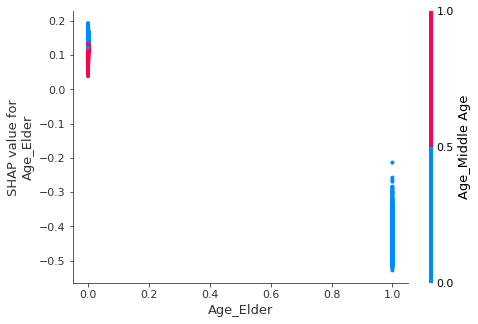

In [102]:

shap.dependence_plot("Age_Elder", shap_values[0], x_train_dummy_norm)


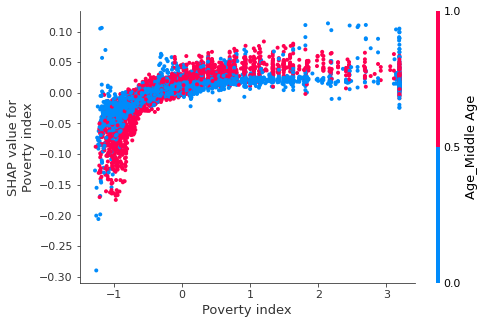

In [103]:
shap.dependence_plot("Poverty index", shap_values[0],x_train_dummy_norm )


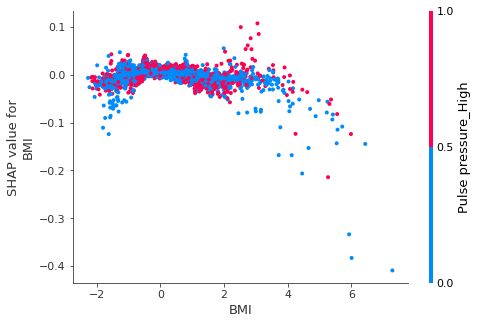

In [104]:
shap.dependence_plot("BMI", shap_values[0], x_train_dummy_norm)


> Model 4: XGBoost



In [105]:
import xgboost
xgb_train = xgboost.DMatrix(x_train_dummy_norm, label=y_train)
xgb_test = xgboost.DMatrix(x_test_dummy_norm, label=y_test)

> Model 5: Adaboost with baseline decision tree model (max depth = 3) as base classifier

In [106]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=1000,
    learning_rate=.1)
adaboost.fit(x_train_dummy_norm,y_train)
ada_pred_train = adaboost.predict(x_train_dummy_norm)
ada_pred_test = adaboost.predict(x_test_dummy_norm)
acc_ada_train = accuracy_score(y_train,ada_pred_train)
acc_ada_test = accuracy_score(y_test,ada_pred_test)
print('Adaboost model: Accuracy on train set is ',str(round(acc_ada_train,4)))
print('Adaboost model: Accuracy on test set is ',str(round(acc_ada_test,4)))


Adaboost model: Accuracy on train set is  0.9317
Adaboost model: Accuracy on test set is  0.7937


> Model 6: LSTM 

In [107]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 4, activation = 'sigmoid', input_shape = (None, x_train_dummy_norm.shape[1])),
    tf.keras.layers.Dense(units = 1)]
)

In [108]:
np.array(x_train_dummy_norm).shape

(7945, 24)

In [109]:
# If use the entirely transformed result
model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = 'accuracy')
filename = "best_model.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

X_train = np.reshape(np.array(x_train_dummy_norm), (x_train_dummy_norm.shape[0], 1, x_train_dummy_norm.shape[1]))
hist = model.fit(X_train, y_train, batch_size = 64, epochs = 2000, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/2000
100/100 [==============================] - 0s 4ms/step - loss: 0.8634 - accuracy: 0.6191 - val_loss: 0.6756 - val_accuracy: 0.6130
Epoch 2/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6515 - val_loss: 0.6222 - val_accuracy: 0.6778
Epoch 3/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5951 - accuracy: 0.7052 - val_loss: 0.5838 - val_accuracy: 0.7080
Epoch 4/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.7324 - val_loss: 0.5553 - val_accuracy: 0.7325
Epoch 5/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5356 - accuracy: 0.7604 - val_loss: 0.5296 - val_accuracy: 0.7546
Epoch 6/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.7642 - val_loss: 0.5152 - val_accuracy: 0.7621
Epoch 7/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.7755 - val_loss: 0.4998 - val_accuracy:

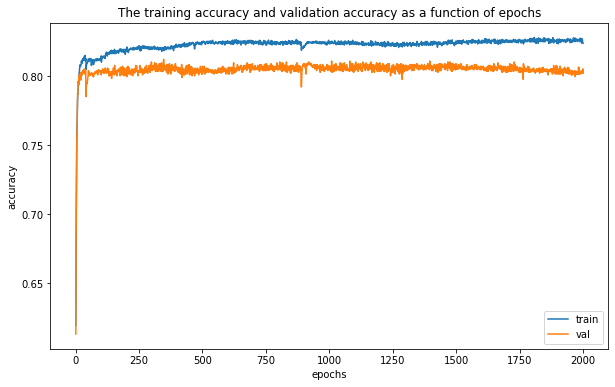

In [110]:
plt.figure(figsize=(10,6))
plt.plot(list(range(1, 2001)), hist.history['accuracy'], label = 'train')
plt.plot(list(range(1, 2001)), hist.history['val_accuracy'], label = 'val')
plt.title('The training accuracy and validation accuracy as a function of epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [111]:
model.load_weights("best_model.h5")
X_test = np.reshape(np.array(x_test_dummy_norm), (x_test_dummy_norm.shape[0], 1, x_test_dummy_norm.shape[1]))
lstm_pred = model.predict_classes(X_test)
accuracy_score(y_test,lstm_pred)
#lstm_pred

0.8147961751383996

In [112]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=150, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape = (None, x_train_dummy_norm.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(64, activation='relu', input_shape = (None, x_train_dummy_norm.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences = True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')]
)
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
filename = "best_model2.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

X_train = np.reshape(np.array(x_train_dummy_norm), (x_train_dummy_norm.shape[0], 1, x_train_dummy_norm.shape[1]))
hist = model_lstm.fit(X_train, y_train, batch_size = 256, epochs = 1000, validation_split=0.2, callbacks=[checkpoint, callback])

Epoch 1/1000
25/25 [==============================] - 1s 30ms/step - loss: 0.6904 - accuracy: 0.6440 - val_loss: 0.6872 - val_accuracy: 0.6451
Epoch 2/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6812 - accuracy: 0.6517 - val_loss: 0.6693 - val_accuracy: 0.6451
Epoch 3/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6310 - accuracy: 0.6517 - val_loss: 0.5930 - val_accuracy: 0.6451
Epoch 4/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.5745 - accuracy: 0.6529 - val_loss: 0.5467 - val_accuracy: 0.6526
Epoch 5/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.5129 - accuracy: 0.7613 - val_loss: 0.4757 - val_accuracy: 0.7885
Epoch 6/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.4605 - accuracy: 0.7981 - val_loss: 0.4480 - val_accuracy: 0.7992
Epoch 7/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.4334 - accuracy: 0.8090 - val_loss: 0.4355 - val_accuracy: 0.8037

In [113]:
model_lstm.load_weights("best_model2.h5")
X_test = np.reshape(np.array(x_test_dummy_norm), (x_test_dummy_norm.shape[0], 1, x_test_dummy_norm.shape[1]))
lstm_pred = model_lstm.predict_classes(X_test)
accuracy_score(y_test,lstm_pred)

0.8213387015601409

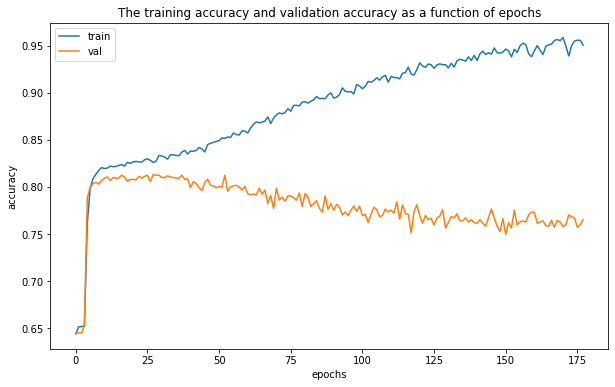

In [114]:
plt.figure(figsize=(10,6))
plt.plot(list(range(len(hist.history['accuracy']))), hist.history['accuracy'], label = 'train')
plt.plot(list(range(len(hist.history['accuracy']))), hist.history['val_accuracy'], label = 'val')
plt.title('The training accuracy and validation accuracy as a function of epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

## Appendix

In [115]:
features=['Red blood cells','Diastolic BP', 'Poverty index','Sedimentation rate', 'Serum Albumin','Serum Cholesterol','Systolic BP','TIBC','TS',\
          'Serum Iron','Serum Magnesium','Serum Protein','White blood cells','BMI','Pulse pressure']
dataplot=pd.DataFrame()
for f in features:
    a=np.nanquantile(data[f],[0,0.25,0.5,0.75,1])
    dataplot[f]=pd.cut(data[f],a,labels=['0-25q','25q-50q','50q-75q','75q-1'])
    dataplot[f]= dataplot[f].cat.add_categories('missing')
dataplot=dataplot.fillna(value='missing')
dataplot.info()
                 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Red blood cells     9932 non-null   category
 1   Diastolic BP        9932 non-null   category
 2   Poverty index       9932 non-null   category
 3   Sedimentation rate  9932 non-null   category
 4   Serum Albumin       9932 non-null   category
 5   Serum Cholesterol   9932 non-null   category
 6   Systolic BP         9932 non-null   category
 7   TIBC                9932 non-null   category
 8   TS                  9932 non-null   category
 9   Serum Iron          9932 non-null   category
 10  Serum Magnesium     9932 non-null   category
 11  Serum Protein       9932 non-null   category
 12  White blood cells   9932 non-null   category
 13  BMI                 9932 non-null   category
 14  Pulse pressure      9932 non-null   category
dtypes: category(15)
memory usage: 148.5 KB

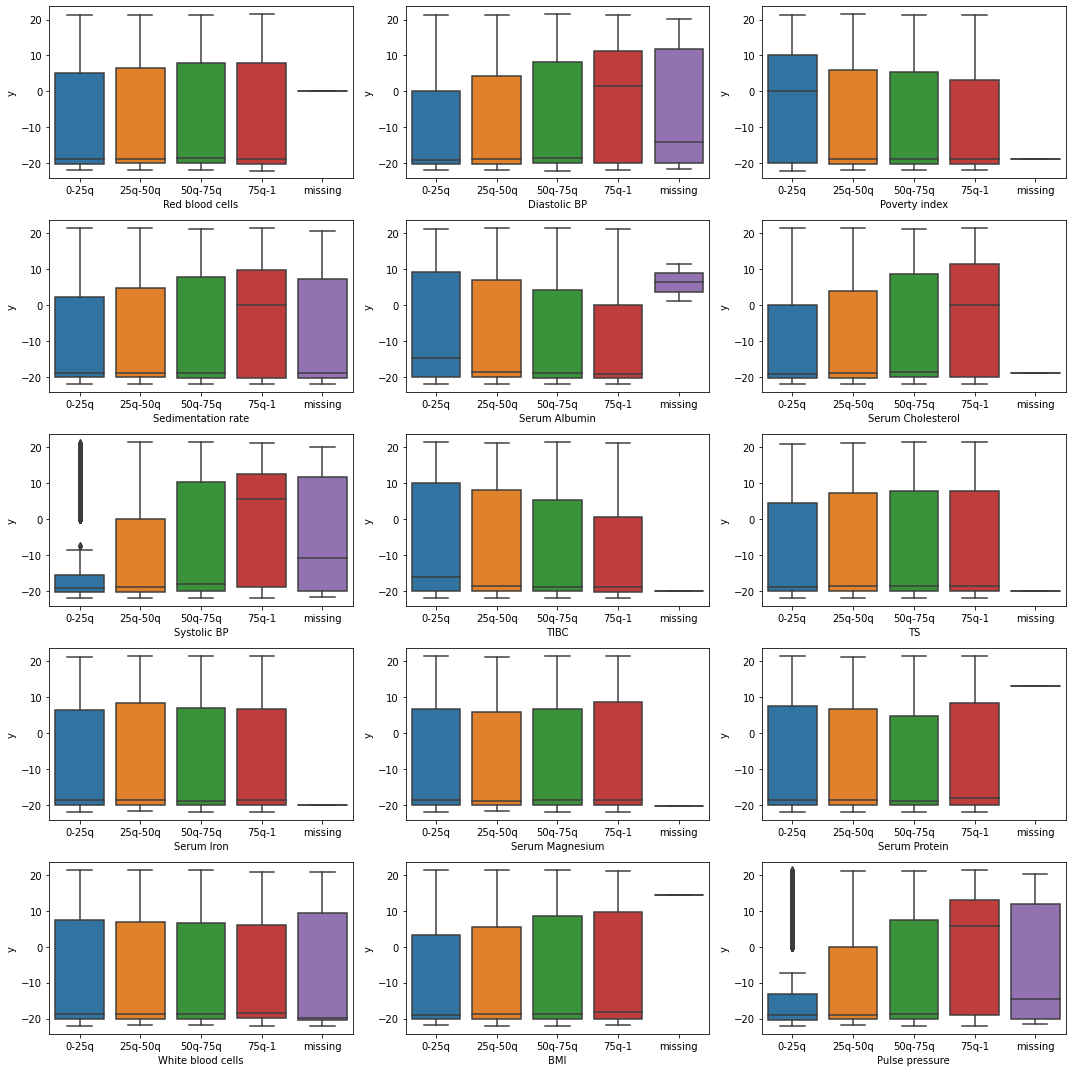

In [116]:
fig,ax=plt.subplots(5,3,figsize=(15,15))
ax=ax.ravel()
for i,f in enumerate(features):
    sns.boxplot(x=dataplot[f],y=data['y'],ax=ax[i])
plt.tight_layout()

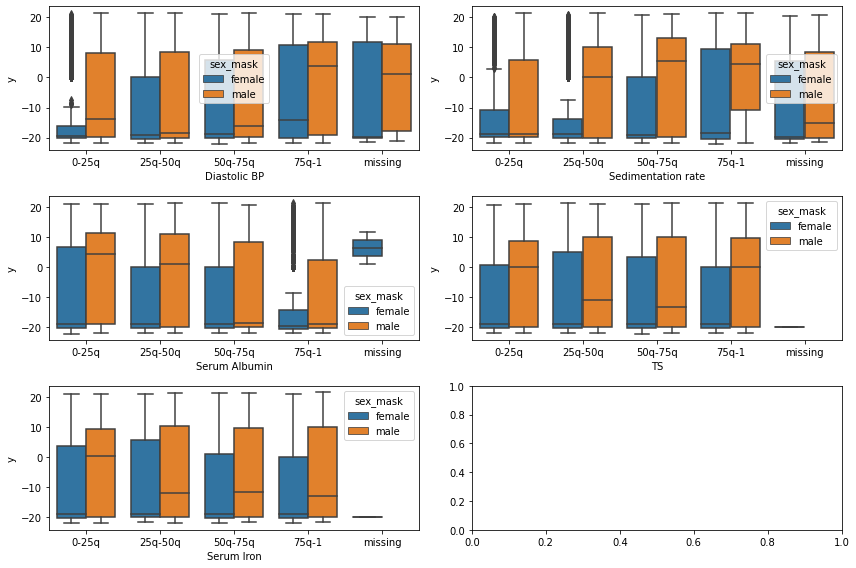

In [117]:
#features=['Diastolic BP', 'Sedimentation rate', 'Serum Albumin','TS', 'Serum Iron','Age']
fig,ax=plt.subplots(3,2,figsize=(12,8))
ax=ax.ravel()
data['sex_mask']=data['Sex'].replace({1:'male',2:'female'})
data['race_mask']=data['Race'].replace({1:'white',2:'other',3:'black'})
for i,f in enumerate(['Diastolic BP', 'Sedimentation rate', 'Serum Albumin','TS', 'Serum Iron']):
    sns.boxplot(x=dataplot[f],y=data['y'],hue=data['sex_mask'],ax=ax[i])
plt.tight_layout()

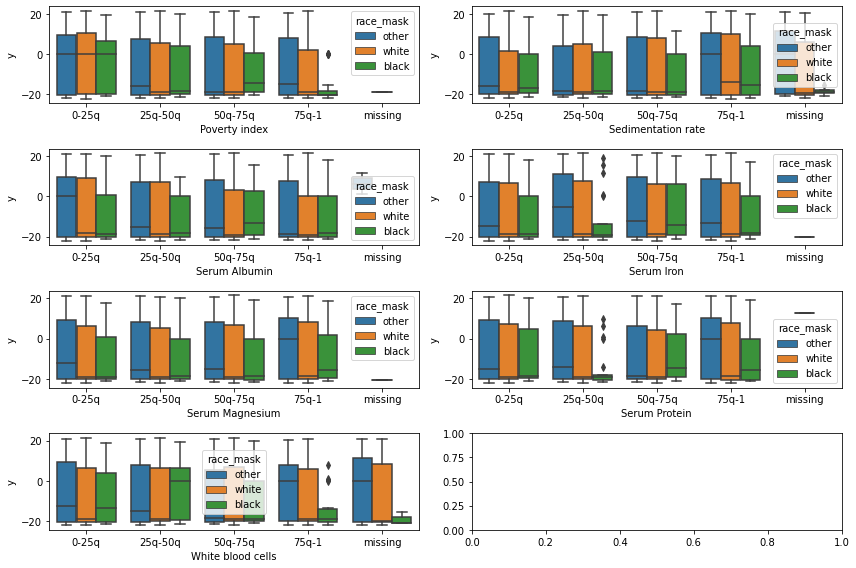

In [118]:
#features=['Poverty index', 'Sedimentation rate', 'Serum Albumin','Serum Iron','Serum Magnesium','Serum Protein','White blood cells']
fig,ax=plt.subplots(4,2,figsize=(12,8))
ax=ax.ravel()
for i,f in enumerate(['Poverty index', 'Sedimentation rate', 'Serum Albumin','Serum Iron','Serum Magnesium','Serum Protein','White blood cells']):
    sns.boxplot(x=dataplot[f],y=data['y'],hue=data['race_mask'],ax=ax[i])
plt.tight_layout()
